In [2]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [28]:
results = h5py.File("glove-25-100k-1k.hdf5", "r")
data = h5py.File("../../data/glove-25-angular.hdf5", "r")

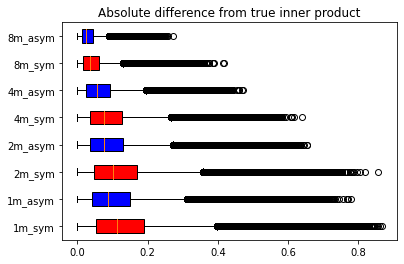

In [5]:
inner_prods = results["True_innner_product"][:]
inner_prods = inner_prods.reshape(inner_prods.shape[0] * inner_prods.shape[1])
all_diffs = []
labels = []
for m in [ 2**val for val in range(0,4)]:
    name = "%dm" % m
    symd    = results[name]["Symmetric_distance"][:]
    asymd   = results[name]["Asymmetric_distance"][:]
    symd = symd.reshape(symd.shape[0]*symd.shape[1])
    asymd = asymd.reshape(asymd.shape[0]*asymd.shape[1])
    symd_diff = np.abs(inner_prods - symd)
    asymd_diff = np.abs(inner_prods - asymd)
    all_diffs.append(symd_diff)
    labels.append(name + "_sym")
    all_diffs.append(asymd_diff)
    labels.append(name + "_asym")

bplot = plt.boxplot(all_diffs, vert=False, patch_artist=True, labels=labels)
for idx, patch in enumerate(bplot["boxes"]):
    patch.set_facecolor("red" if (idx%2==0) else "blue")

plt.title("Absolute difference from true inner product")
plt.show()



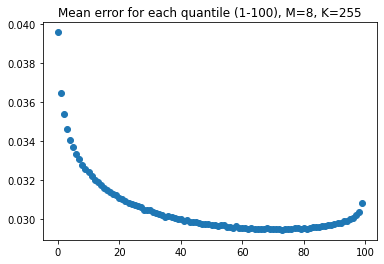

In [6]:
order = np.argsort(inner_prods)
m8_a = results["8m"]["Asymmetric_distance"][:]

m8_a = m8_a.reshape(m8_a.shape[0] * m8_a.shape[1])
m8_a_diffs = np.abs(inner_prods - m8_a)
m8_a_diffs = m8_a_diffs[order]
ordered_inner = inner_prods[order]

bins = 100
step = ordered_inner.shape[0]//bins

avgs = []
for i in range(bins):
    m8_a_sec = m8_a_diffs[i*step:(i+1)*step]
    avgs.append(np.mean(m8_a_sec))

scat = plt.scatter(range(bins),avgs)
plt.title("Mean error for each quantile (1-100), M=8, K=255")
plt.show()

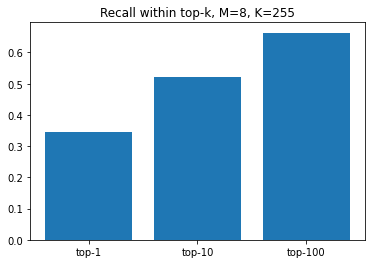

In [7]:

recalls = [0 for _ in range(3)]
for q, ans in zip(results["8m"]["Asymmetric_distance"], results["True_innner_product"]): 
    q_order = np.argsort(q)
    ans_order = np.argsort(ans)
    for i in range(3):
        top_k = 10**i
        intersection = np.intersect1d(q_order[:top_k], ans_order[:top_k])
        recalls[i]+= len(intersection)
for i in range(3):
    recalls[i] /= ((10**i)*results["True_innner_product"].shape[0])
plt.title("Recall within top-k, M=8, K=255")
plt.bar(["top-%d" % 10**i for i in range(3)], recalls)
plt.show()



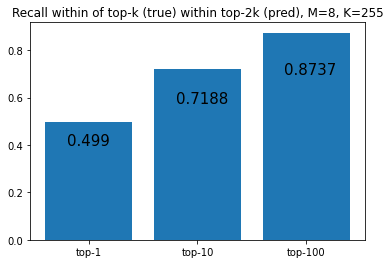

In [8]:
recalls = [0 for _ in range(3)]
for q, ans in zip(results["8m"]["Asymmetric_distance"], results["True_innner_product"]): 
    q_order = np.argsort(q)
    ans_order = np.argsort(ans)
    for i in range(3):
        top_k = 10**i
        intersection = np.intersect1d(q_order[:top_k*2], ans_order[:top_k])
        recalls[i]+= len(intersection)
for i in range(3):
    recalls[i] /= ((10**i)*results["True_innner_product"].shape[0])
plt.title("Recall within of top-k (true) within top-2k (pred), M=8, K=255")
plt.bar(["top-%d" % 10**i for i in range(3)], recalls)

for i in range(3):
    plt.text(x = i-0.2, y = recalls[i]-0.2*recalls[i], s = str(recalls[i]), size = 15)
plt.show()


In [13]:
bins = 100

needed = [[] for _ in range(bins)]
for q, ans in zip(results["8m"]["Asymmetric_distance"], results["True_innner_product"]): 
    q_order = np.argsort(q)
    ans_order = np.argsort(ans)
    for i in range(bins):
        top_k = i+1
        set_ans_order = set(ans_order[:top_k])
        j = 0
        while len(set_ans_order) > 0:
            if q_order[j] in set_ans_order:
                set_ans_order.remove(q_order[j])
            j += 1
        needed[i].append(j)
need_arr = np.array(needed)



In [49]:
colormap = cm.get_cmap("Reds")
p = 11
percentiles = np.linspace(0,100,p)
p_data = np.zeros((need_arr.shape[0], p))
half = (p-1)//2
for i, row in enumerate(need_arr):
    row_p = np.percentile(row, percentiles)
    for j in range(p):
        p_data[i,j] = row_p[j]


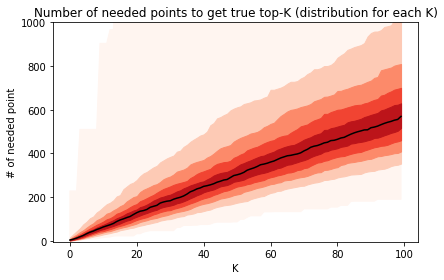

In [50]:
x_vals = list(range(bins))
plt.plot(x_vals, p_data[:,half], color="k")
for i in range(half):
    plt.fill_between(x_vals, p_data[:,i], p_data[:,-(i+1)], color = colormap(i/half))
plt.title("Number of needed points to get true top-K (distribution for each K)")
plt.xlabel("K")
plt.ylabel("# of needed point")
plt.tight_layout()
plt.gca().set_ylim([-5, 1000])
plt.show()

In [32]:
recalls = np.zeros((3,10))
for q, ans in zip(results["8m"]["Asymmetric_distance"], results["True_innner_product"]): 
    q_order = np.argsort(q)
    ans_order = np.argsort(ans)
    for i in range(1,11):
        for pow in range(3):
            top_k = 10**pow
            intersection = np.intersect1d(q_order[:top_k*i], ans_order[:top_k])
            recalls[pow,(i-1)]+= len(intersection)
recalls[0,:] /= results["True_innner_product"].shape[0]
recalls[1,:] /= 10*results["True_innner_product"].shape[0]
recalls[2,:] /= 100*results["True_innner_product"].shape[0]

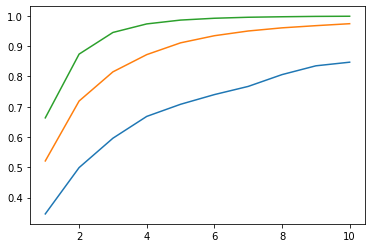

In [34]:
plt.plot(range(1,11),recalls[0])
plt.plot(range(1,11),recalls[1])
plt.plot(range(1,11),recalls[2])

### Comparing mahalanobis optimization to euclidean optimization

In [3]:
maha_euc_r = h5py.File("euc_maha_comp.hdf5", "a")

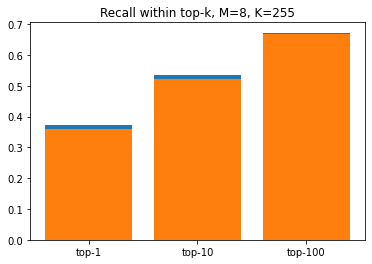

In [9]:
maha_recalls = [0 for _ in range(3)]
euc_recalls = [0 for _ in range(3)]
for q_maha, q_euc, ans in zip(maha_euc_r["8m"]["Maha_dist_asym"], maha_euc_r["8m"]["Euc_dist_asym"], maha_euc_r["True_innner_product"]): 

    q_maha_order = np.argsort(q_maha)
    q_euc_order =  np.argsort(q_euc)
    ans_order = np.argsort(ans)

    for i in range(3):
        top_k = 10**i
        maha_intersection = np.intersect1d(q_maha_order[:top_k], ans_order[:top_k])
        euc_intersection = np.intersect1d(q_euc_order[:top_k], ans_order[:top_k])
        maha_recalls[i]+= len(maha_intersection)
        euc_recalls[i]+= len(euc_intersection)
    
for i in range(3):
    maha_recalls[i] /= ((10**i)*maha_euc_r["True_innner_product"].shape[0])
    euc_recalls[i]  /= ((10**i)*maha_euc_r["True_innner_product"].shape[0])

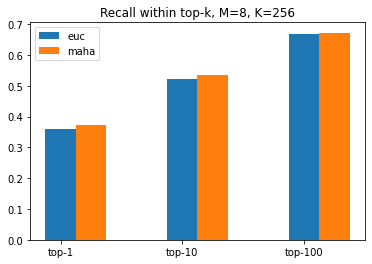

In [20]:
barWidth = 0.25
plt.title("Recall within top-k, M=8, K=256")
x_labels = ["top-%d" % 10**i for i in range(3)]
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
plt.bar(br1, euc_recalls, label = "euc", width = barWidth )
plt.bar(br2, maha_recalls, label = "maha", width = barWidth )
plt.xticks([r + barWidth//2 for r in range(3)],
        x_labels)
plt.legend()
plt.show()

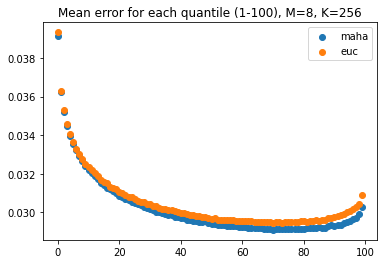

In [26]:
inner_prods = maha_euc_r["True_innner_product"][:].reshape(-1)
order = np.argsort(inner_prods)

maha_m8_a = maha_euc_r["8m"]["Maha_dist_asym"][:]
euc_m8_a = maha_euc_r["8m"]["Euc_dist_asym"][:]

maha_m8_a = maha_m8_a.reshape(maha_m8_a.shape[0] * maha_m8_a.shape[1])
euc_m8_a  = euc_m8_a.reshape(euc_m8_a.shape[0] * euc_m8_a.shape[1])

maha_m8_a_diffs = np.abs(inner_prods - maha_m8_a)
euc_m8_a_diffs = np.abs(inner_prods - euc_m8_a)

maha_m8_a_diffs = maha_m8_a_diffs[order]
euc_m8_a_diffs = euc_m8_a_diffs[order]

ordered_inner = inner_prods[order]

bins = 100
step = ordered_inner.shape[0]//bins

maha_avgs = []
euc_avgs = []
for i in range(bins):
    maha_m8_a_sec = maha_m8_a_diffs[i*step:(i+1)*step]
    euc_m8_a_sec  = euc_m8_a_diffs[i*step:(i+1)*step]
    maha_avgs.append(np.mean(maha_m8_a_sec))
    euc_avgs.append(np.mean(euc_m8_a_sec))

plt.scatter(range(bins),maha_avgs, label = "maha")
plt.scatter(range(bins),euc_avgs, label = "euc")
plt.title("Mean error for each quantile (1-100), M=8, K=256")
plt.legend()
plt.show()

In [2]:
euc = h5py.File("inertia_variance_euc.hdf5", "r")
maha = h5py.File("inertia_variance_maha.hdf5", "r")

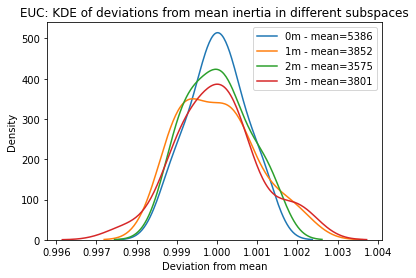

In [25]:
for key in euc.keys():
    m = np.mean(euc[key])
    d = euc[key]/m
    sns.kdeplot(d, label = key + " - mean=" + str(int(m)))
plt.title("EUC: KDE of deviations from mean inertia in different subspaces")
plt.xlabel("Deviation from mean")
plt.legend()
plt.show()

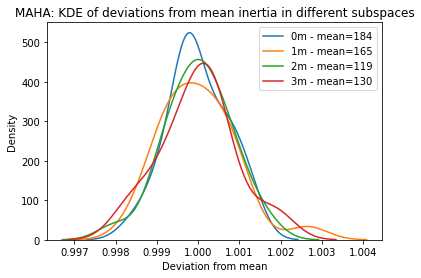

In [24]:
for key in maha.keys():
    m = np.mean(maha[key])
    d = maha[key]/m
    sns.kdeplot(d, label = key + " - mean=" + str(int(m)))
plt.title("MAHA: KDE of deviations from mean inertia in different subspaces")
plt.xlabel("Deviation from mean")
plt.legend()
plt.show()

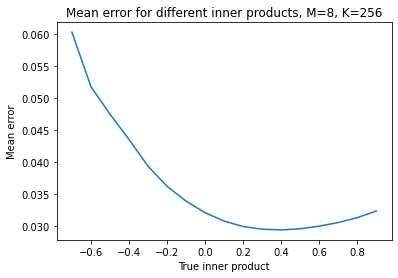

In [19]:

test = h5py.File("test.hdf5", "r")

inner_prods = test["True_innner_product"][:].reshape(-1)
order = np.argsort(inner_prods)

m4_a = test["8m"]["Asymmetric_distance"][:]

m4_a = m4_a.reshape(-1)

diffs = np.abs(inner_prods - m4_a)

diffs = diffs[order]

ordered_inner = inner_prods[order]

bins = 100
step_size = 0.1

prev = 0
bin = -0.9
xs = []
ys = []
while bin <= 1:
    new = np.argmax(ordered_inner > bin)
    section = diffs[prev:new]
    if section.shape[0]:
        xs.append(bin)
        ys.append(np.mean(section))

    prev = new
    bin += step_size

plt.plot(xs,ys)
plt.title("Mean error for different inner products, M=8, K=256")
plt.xlabel("True inner product")
plt.ylabel("Mean error")
plt.show()

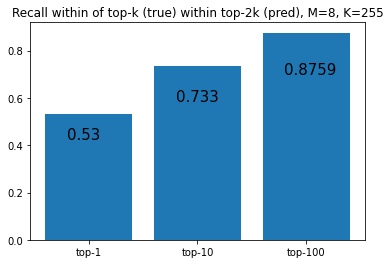

df = pd.DataFrame(np.array(), columns=["Estimated", "True"])

In [5]:
df.head(20)

,Estimated,True
0,0.987946,0.986572
1,0.931580,0.982178
2,0.966034,0.979279
3,0.993866,0.973969
4,0.916351,0.972260
5,0.939087,0.971527
6,0.957397,0.971161
7,0.887390,0.971039
8,0.937408,0.969421
9,0.896851,0.968842


(array([1.913000e+03, 9.210000e+02, 4.700300e+04, 5.212870e+05,
        2.182942e+06, 3.710906e+06, 2.427248e+06, 8.915170e+05,
        1.912230e+05, 2.504000e+04]),
 array([-1.0000000e+00, -8.0000305e-01, -6.0000610e-01, -4.0000916e-01,
        -2.0001221e-01, -1.5258789e-05,  1.9998169e-01,  3.9997864e-01,
         5.9997559e-01,  7.9997253e-01,  9.9996948e-01], dtype=float32),
 <BarContainer object of 10 artists>)

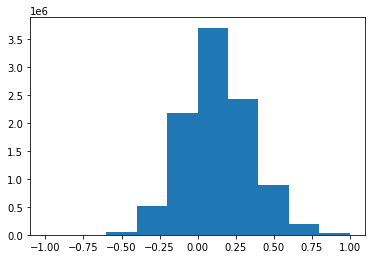

In [7]:
plt.hist(df["Estimated"])

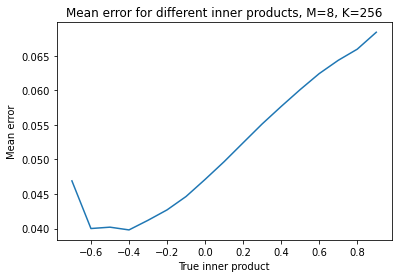

In [3]:

test = h5py.File("g25_angd.hdf5", "r")

inner_prods = test["True_inner_product"][:].reshape(-1)
order = np.argsort(inner_prods)

m8_a = test["8m"]["Asymmetric_distance"][:]

m8_a = m8_a.reshape(-1)

diffs = np.abs(inner_prods - m8_a)

diffs = diffs[order]

ordered_inner = inner_prods[order]

bins = 100
step_size = 0.1

prev = 0
bin = -0.9
xs = []
ys = []
while bin <= 1:
    new = np.argmax(ordered_inner > bin)
    section = diffs[prev:new]
    if section.shape[0]:
        xs.append(bin)
        ys.append(np.mean(section))

    prev = new
    bin += step_size

plt.plot(xs,ys)
plt.title("Mean error for different inner products, M=8, K=256")
plt.xlabel("True inner product")
plt.ylabel("Mean error")
plt.show()

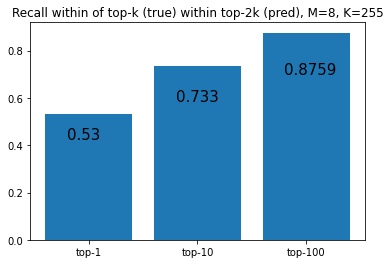

array([0.9544678 , 0.9568176 , 0.9600525 , 0.96139526, 0.9621277 ,
       0.9623413 , 0.9638977 , 0.96698   , 0.9674072 , 0.9684448 ,
       0.96884155, 0.9694214 , 0.9710388 , 0.9711609 , 0.9715271 ,
       0.9722595 , 0.9739685 , 0.97927856, 0.98217773, 0.98657227],
      dtype=float32)

In [14]:
recalls = [0 for _ in range(3)]
for q, ans in zip(test["8m"]["Asymmetric_distance"], test["True_inner_product"]): 
    q_order = np.argsort(q)
    ans_order = np.argsort(ans)
    for i in range(3):
        top_k = 10**i
        intersection = np.intersect1d(q_order[:top_k*2], ans_order[:top_k])
        recalls[i]+= len(intersection)
for i in range(3):
    recalls[i] /= ((10**i)*test["True_inner_product"].shape[0])
plt.title("Recall within of top-k (true) within top-2k (pred), M=8, K=255")
plt.bar(["top-%d" % 10**i for i in range(3)], recalls)

for i in range(3):
    plt.text(x = i-0.2, y = recalls[i]-0.2*recalls[i], s = str(recalls[i]), size = 15)
plt.show()
ordered_inner[-20:].T

In [30]:

m8_a[order][-20:][::-1] + 0.08

array([0.9373608 , 0.85008055, 0.9140759 , 0.9528027 , 1.00276   ,
       0.9763318 , 0.9638501 , 0.92942625, 0.9241772 , 0.88200194,
       0.94849974, 0.9369946 , 0.9961377 , 0.90266234, 0.89140135,
       0.97993284, 0.95942503, 0.97785765, 0.9829846 , 1.0240613 ],
      dtype=float32)

In [33]:
ordered_inner[::-1][:20]

array([0.94869995, 0.9185791 , 0.85879517, 0.84503174, 0.8371582 ,
       0.8364258 , 0.81832886, 0.81329346, 0.80526733, 0.80493164,
       0.7996826 , 0.7928772 , 0.789978  , 0.7895813 , 0.78601074,
       0.78564453, 0.7855835 , 0.7833252 , 0.7821655 , 0.78186035],
      dtype=float32)

In [50]:

m8_a = test["8m"]["Asymmetric_distance"][:]
inner_prods = test["True_inner_product"][:]

In [57]:
best_r = np.min(inner_prods, key = lambda k : sum(sorted(k, reverse=True)[:20]))

In [58]:
sorted(best_r, reverse = True)

[0.46951294,
 0.43286133,
 0.42926025,
 0.42797852,
 0.41711426,
 0.412323,
 0.39691162,
 0.39434814,
 0.39379883,
 0.38998413,
 0.38879395,
 0.3887329,
 0.38858032,
 0.38528442,
 0.38357544,
 0.38137817,
 0.38012695,
 0.37704468,
 0.3768921,
 0.37628174,
 0.37408447,
 0.37332153,
 0.37200928,
 0.3715515,
 0.37008667,
 0.37008667,
 0.36709595,
 0.3592224,
 0.35849,
 0.35784912,
 0.35446167,
 0.35403442,
 0.35372925,
 0.35302734,
 0.35302734,
 0.35107422,
 0.35012817,
 0.34991455,
 0.34814453,
 0.34729004,
 0.34716797,
 0.34661865,
 0.34655762,
 0.34588623,
 0.34576416,
 0.34506226,
 0.34375,
 0.34292603,
 0.3420105,
 0.34188843,
 0.34170532,
 0.34158325,
 0.3407898,
 0.34075928,
 0.34075928,
 0.34014893,
 0.33795166,
 0.337677,
 0.33764648,
 0.33721924,
 0.33718872,
 0.33676147,
 0.33547974,
 0.3345642,
 0.33441162,
 0.33410645,
 0.33392334,
 0.33306885,
 0.33258057,
 0.33239746,
 0.3321228,
 0.33151245,
 0.33087158,
 0.33065796,
 0.33050537,
 0.3300476,
 0.32928467,
 0.32904053,
 0.32